In [1]:
import argparse
import os, sys
import time
import datetime
import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from Resnet20model import Resnet20

In [2]:
#############################################
# sanity check for the correctness of Resnet20 architecture
dummy_input = torch.ones((1,3,32,32))
dummy_instance = Resnet20()
print(dummy_instance.forward(dummy_input))
total_params = 1
for p in dummy_instance.parameters():
    temp = 1
    for s in p.size():
        temp *= s
    total_params += temp
    #print(p.size())
print(f"Total Number of Parameters: {total_params}")
#############################################

tensor([[-0.3969, -0.0654,  0.0389,  0.6609, -0.2705, -0.0791, -0.2138,  0.2067,
          0.0348, -0.1804]], grad_fn=<AddmmBackward0>)
Total Number of Parameters: 273067


In [3]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10 as torchCIFAR10

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
rndimg_mean = (136.289, 129.273,122.668)
rndimg_std  = (49.770, 49.016, 49.5022508)

# specify preprocessing function
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std),
                                     transforms.RandomCrop(size=32, padding=4),
                                     transforms.RandomHorizontalFlip()])
tensor_transform_train = transforms.Compose([transforms.Normalize(rndimg_mean, rndimg_std),
                                     transforms.RandomCrop(size=32, padding=4),
                                     transforms.RandomHorizontalFlip()])

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_visulaizer = transforms.Compose([transforms.ToTensor()])

In [4]:
# Custom dataset class for tensor datasets. (Allows transforms)

class OODTensorDataset:
    def __init__(self, tensor_data, transforms=None):
        self.tensors = tensor_data
        self.transforms = transforms
    
    def __getitem__(self, index):   
        x = self.tensors[index]
        if self.transforms:
            x = self.transforms(x)
        return x, -1                 # returing -1 for OOD labels to signify that they dont matter
    
    def __len__(self):
        return self.tensors.size()[0]


##### Set up Data loaders

In [5]:
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset

DATA_ROOT = "./data"
OOD_TRAIN_BATCH_SIZE = 256
ID_TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100


# construct dataset
torch_train_set = torchCIFAR10(
    root=DATA_ROOT,
    train=True,
    transform=transform_train,
    download=True
)
all_testing = torchCIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)

cifar5_train_labels = np.array(torch_train_set.targets)
cifar5_test_labels = np.array(all_testing.targets)
train_indices = []
all_test_indices = []
for i in [0,1,2,3,4]:
    train_indices += np.where(cifar5_train_labels == i)[0].tolist()
    all_test_indices += np.where(cifar5_test_labels == i)[0].tolist()
cifar5_train_set = Subset(torch_train_set, train_indices)
cifar5_test_set = Subset(all_testing, all_test_indices)

# construct dataloader
torch_train_loader = DataLoader(
    torch_train_set,
    batch_size = ID_TRAIN_BATCH_SIZE,
    shuffle = True
)
torch_test_loader = DataLoader(
    all_testing,
    batch_size = VAL_BATCH_SIZE
)
torch_val_loader = DataLoader(
    all_testing,
    batch_size = VAL_BATCH_SIZE
)
cifar5_train_loader = DataLoader(
    cifar5_train_set,
    batch_size = ID_TRAIN_BATCH_SIZE,
    shuffle = True
)
cifar5_test_loader = DataLoader(
    cifar5_test_set,
    batch_size = VAL_BATCH_SIZE
)


from torchvision.datasets import CIFAR100

cifar100_set = CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)

cifar100_loader = DataLoader(
    cifar100_set,
    shuffle=True,
    batch_size = OOD_TRAIN_BATCH_SIZE
)

cifar100_labels = np.array(cifar100_set.targets)
train_1_indices = []
train_1_indices += np.where(cifar100_labels == 1)[0].tolist()
cifar1_set = Subset(cifar100_set, train_1_indices)

cifar_1_loader = DataLoader(
    cifar1_set,
    batch_size = OOD_TRAIN_BATCH_SIZE,
    shuffle = True,
)

train_5_indices = []
for i in range(5):
    train_5_indices += np.where(cifar100_labels == i)[0].tolist()
cifar100_5_set = Subset(cifar100_set, train_5_indices)

cifar100_5_loader = DataLoader(
    cifar100_5_set,
    batch_size = OOD_TRAIN_BATCH_SIZE,
    shuffle = True
)
cifar100_5_loader_for_extra = DataLoader(
    cifar100_5_set
)

train_20_indices = []
for i in range(20):
    train_20_indices += np.where(cifar100_labels == i)[0].tolist()
cifar100_20_set = Subset(cifar100_set, train_20_indices)

cifar100_20_loader = DataLoader(
    cifar100_20_set,
    batch_size = OOD_TRAIN_BATCH_SIZE,
    shuffle = True
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# RANDOM_IMGS = "./data/300K_random_images.npy"

# # construct dataset
# random_images_data = torch.permute(torch.from_numpy(np.load(RANDOM_IMGS)), (0,3,1,2)).float()  
# rand_img_set = OODTensorDataset(
#     random_images_data,
#     tensor_transform_train
# )
# # construct dataloader
# train_loader_rand_ood = DataLoader(
#     rand_img_set,
#     batch_size = OOD_BATCH_SIZE,
#     shuffle = True
# )


In [7]:
def energy_fun(cnn_output, T):
  return -T* torch.logsumexp(cnn_output / T, dim=1)

In [8]:
def estimate_mean_and_std(npdata, N=1000):
    pavg   = np.array([0.0, 0.0, 0.0])
    stdavg = np.array([0.0, 0.0, 0.0])
    for img in npdata[0:N]:
        scale = 1/(img.shape[0]*img.shape[1])
        pavg += np.sum(img*scale,(0,1))*(1/N)
    print(pavg)
        #pavg_sq += np.sum((img**2)*scale,(0,1))*(1/N)
    #std = np.sqrt(pavg_sq-(pavg**2))
    for img in npdata[0:N]:
        # scale = 1/(img.shape[0]*img.shape[1])
        # sqdiff = np.subtract(img, pavg)**2
        # std = np.sqrt(np.sum(sqdiff,(0,1))*scale)
        stdavg += np.std(img,(0,1)) *(1/N)
    
    print(stdavg)
#estimate_mean_and_std(np.load(RANDOM_IMGS).astype("int32"))

In [9]:
# specify the device for computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
net = Resnet20().to(device)
#net.load_state_dict(torch.load("saved_model/resnet20.pth")["state_dict"])

In [11]:
import torch.nn as nn
import torch.optim as optim

WARMUP_LR = .01
MOMENTUM = 0.9
REG = 5e-4
optimizer = optim.SGD(net.parameters(), lr=WARMUP_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 150
CHECKPOINT_FOLDER = "./saved_model"
INITAL_LR = .1
DECAY_EPOCHS = 60
DECAY = .1

In [12]:
def train():
    avg_loss = 0
    best_val_acc = 0
    current_learning_rate = WARMUP_LR
    #train_loader_ood.dataset.offset = np.random.randint(len(train_loader_ood.dataset))
    #Learning rate scheduler
    for i in range(EPOCHS):
        if i == 5:
            current_learning_rate = INITAL_LR
        if i % DECAY_EPOCHS == 0 and i != 0:
            current_learning_rate = current_learning_rate * DECAY
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate
            #print("Current learning rate has decayed to %f" %current_learning_rate)
    
        net.train()
        
        print(f"Epoch: {i}/{EPOCHS}")
        for in_set, out_set in zip(cifar5_train_loader, cifar100_20_loader):
            data = torch.cat((in_set[0], out_set[0]), 0)
            target = in_set[1].type(torch.LongTensor)
            data, target = data.to(device), target.to(device)
            
            # Forward Pass
            x = net.forward(data)
            
            loss = F.cross_entropy(x[:len(in_set[0])], target)
            # cross-entropy from softmax distribution to uniform distribution
            loss += 0.5 * -(x[len(in_set[0]):].mean(1) - torch.logsumexp(x[len(in_set[0]):], dim=1)).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_loss = .8 * avg_loss + float(loss) * 0.2
       
        print(f"avg training loss: {avg_loss}")
        
        
        net.eval()

        total_examples = 0
        correct_examples = 0

        val_loss = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(cifar5_test_loader):
                if batch_idx < (.5*len(cifar5_test_loader)):
                    # copy inputs to device
                    inputs = inputs.to(device)
                    targets = targets.type(torch.LongTensor)
                    targets = targets.to(device)

                    # compute the output and loss
                    output = net.forward(inputs)
                    loss = F.cross_entropy(output, targets)
                    val_loss += loss

                    # count the number of correctly predicted samples in the current batch
                    total_examples += targets.size()[0]
                    batch_preds = torch.argmax(output, dim=1)
                    correct_examples += (batch_preds == targets).int().sum().item()
                else:
                    break

        avg_loss = val_loss / (.5*len(cifar5_test_loader))
        avg_acc = correct_examples / total_examples
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        
        #save the model checkpoint
        # if avg_acc > best_val_acc:
        #     best_val_acc = avg_acc
        #     if not os.path.exists(CHECKPOINT_FOLDER):
        #        os.makedirs(CHECKPOINT_FOLDER)
        #     print("Saving ...")
        #     state = {'state_dict': net.state_dict(),
        #             'epoch': i,
        #             'lr': current_learning_rate}
        #     torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'cifar5_cifar20_OOD_resnet.pth'))

    
train()

Epoch: 0/150
avg training loss: 2.6928358717321785
Validation loss: 2.3016, Validation accuracy: 0.0000
Epoch: 1/150
avg training loss: 2.784970283508301
Validation loss: 2.3224, Validation accuracy: 0.0000
Epoch: 2/150
avg training loss: 2.7122745513916016
Validation loss: 2.6890, Validation accuracy: 0.0196
Epoch: 3/150
avg training loss: 2.6964664459228516
Validation loss: 2.0146, Validation accuracy: 0.1892
Epoch: 4/150
avg training loss: 2.5327587127685547
Validation loss: 1.8545, Validation accuracy: 0.2396
Epoch: 5/150
avg training loss: 2.471428155899048
Validation loss: 1.1436, Validation accuracy: 0.6116
Epoch: 6/150
avg training loss: 2.3706724643707275
Validation loss: 1.1090, Validation accuracy: 0.6168
Epoch: 7/150
avg training loss: 2.3360044956207275
Validation loss: 1.0492, Validation accuracy: 0.6496
Epoch: 8/150


KeyboardInterrupt: 

In [12]:
def softmax_ODIN(val, T =1000):
    x = val.cpu().detach()
    out = torch.zeros(x.size())

    for i in range(len(out)):
        sum = 0
        for j in range(len(out[0])):
            out[i][j] = np.exp(x[i][j]/T)
            sum+= out[i][j]
        out[i] = out[i]/sum
    return out

In [14]:
net = Resnet20().to(device)
net.load_state_dict(torch.load("saved_model/OE_resnet20.pth")["state_dict"])
net.eval()

val_loss = 0 
T = 1
max_softs_in = []
inD_energy = []
ODIN_softs_in = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(cifar5_test_loader):   #batch_idx, (inputs, targets)
        if batch_idx > .5*len(cifar5_test_loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.type(torch.LongTensor)
            targets = targets.to(device)
            # compute the output and loss
            output = net.forward(inputs)
            softmax = F.softmax(output, dim=1)
            energy_out = energy_fun(output, T)
            loss = F.cross_entropy(output, targets)
            val_loss += loss
            # count the number of correctly predicted samples in the current batch
            batch_preds = torch.argmax(output, dim=1)
            soft_batch_preds = torch.argmax(softmax, dim=1)
            odin_softs = softmax_ODIN(output).amax(1).cpu()
            for i in range(len(softmax)):
                max_softs_in.append(softmax[i][soft_batch_preds[i]].item())
                inD_energy.append(energy_out[i].item())
                ODIN_softs_in.append(odin_softs[i]) 


In [15]:
def plot_roc(ID_vals, OOD_vals, label ):
    TPRs = []     #  true positive rates
    FPRs = []     # false positive rates
    AUROC = []    # will contain the AUROC approximation segments
    opt = .95
    opt2=.05
    opt1_TPR = 0
    opt1_FPR = 0
    distTPR = 1000
    opt2_TPR = 0
    opt2_FPR = 0
    distFPR = 1000
    prev_FPR = 0
    for i in np.linspace(min([min(ID_vals), min(OOD_vals)]), max([max(ID_vals), max(OOD_vals)]), 1000):
        TPR = sum(OOD_vals < i)/len(OOD_vals)
        FPR = sum(ID_vals < i)/len(ID_vals)
        TPRs.append(TPR)
        FPRs.append(FPR)
        AUROC.append((FPR-prev_FPR)*TPR)
        prev_FPR = FPR 
        if(np.abs(opt-TPR)<distTPR):
            opt1_TPR, opt1_FPR, distTPR= TPR, FPR, (np.abs(opt-TPR))
        if(np.abs(opt2-FPR)<distFPR):
            opt2_TPR, opt2_FPR, distFPR= TPR, FPR, (np.abs(opt2-FPR))
    plt.plot(FPRs, TPRs, label = label)
    #plt.plot([0,1], [0,1], "k--", linewidth=.5)
    #plt.xlabel("False Positive Rate")
    #plt.ylabel("True Positive Rate")
    #plt.title(title)

    #plt.plot(opt1_FPR, opt1_TPR, 'X', ms=11, label=f"95% TPR")
    #plt.plot(opt2_FPR, opt2_TPR, 'X', ms=11, label=f"5% FPR")
    #plt.legend()
    print(label)
    print(f"FPR at 95%TPR = {opt1_FPR}")
    print(f"TNR at 95%TPR = {1-opt1_FPR}")
    print(f"AUROC: {sum(AUROC)}")
    print()


In [16]:
def plot_dataset_rocs(ID_datasets, OOD_datasets, title, labels):
    space = np.linspace(0,1,1000)
    tpr95 = [.95]*1000
    plt.plot(space, tpr95, "k--", linewidth=.5, label = "TPR = 95%")
    plt.plot([0,1], [0,1], "k--", linewidth=.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    for i in range(len(OOD_datasets)):
        plot_roc(ID_datasets[i], OOD_datasets[i], labels[i])
        plt.legend()
    plt.show()


In [17]:
from torchvision.datasets import SVHN
from torchvision.datasets import MNIST

###################################################################################
#   SVHN
SVHN_set = SVHN(
    root=DATA_ROOT,
    split="test",
    transform=transform_test,
    download=True
)
SVHN_loader = DataLoader(
    SVHN_set
)

###################################################################################
#   other 5 CIFAR-10
other5_train_indices = []
other5_test_indices = []
for i in [5,6,7,8,9]:
    other5_train_indices += np.where(cifar5_train_labels == i)[0].tolist()
    other5_test_indices += np.where(cifar5_test_labels == i)[0].tolist()
other5_train_set = Subset(torch_train_set, other5_train_indices)
other5_test_set = Subset(all_testing, other5_test_indices)

other5_test_loader = DataLoader(
    other5_test_set
)

###################################################################################
#   MNIST
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda inputs1: inputs1.repeat(3, 1, 1) ),
    transforms.RandomCrop(32, padding=2),
    transforms.Normalize((0.4914), (0.2023)),
    
])
MNIST_OOD_Data = MNIST(
    root=DATA_ROOT,
    train=False,
    transform=transform_MNIST,
    download = True

)
MNIST_OOD_loader = DataLoader(
    MNIST_OOD_Data
)

Using downloaded and verified file: ./data\test_32x32.mat


In [18]:
def generate_softs(testing_loader):
    max_softs = []
    with torch.no_grad():
        for i, (img, target) in enumerate(testing_loader):
            img = img.to(device)
            target = target.type(torch.LongTensor)
            target = target.to(device)

            output = net.forward(img)
            softmax = F.softmax(output, dim=1)
            max_softs.append(softmax[0][torch.argmax(softmax)].item())
            batch_pred = torch.argmax(output, dim=1)
            if i % 2500 == 0:
                print(f"{i}/{len(testing_loader)}")
    return max_softs

In [19]:
def generate_ODIN_softs(testing_loader):
    max_softs = []
    with torch.no_grad():
        for i, (img, target) in enumerate(testing_loader):
            img = img.to(device)
            target = target.type(torch.LongTensor)
            target = target.to(device)

            output = net.forward(img)
            max_softs.append(softmax_ODIN(output).amax(1).cpu().item())
            batch_pred = torch.argmax(output, dim=1)
            if i % 2500 == 0:
                print(f"{i}/{len(testing_loader)}")
    return max_softs
    
def generate_energies(testing_loader):
    energies = []
    with torch.no_grad():
        for i, (img, target) in enumerate(testing_loader):
            img = img.to(device)
            target = target.type(torch.LongTensor)
            target = target.to(device)

            output = net.forward(img)
            energy = energy_fun(output, T)
            energies.append(energy.item())
            if i % 2500 == 0:
                print(f"{i}/{len(testing_loader)}")
    return energies

In [24]:
from sklearn import preprocessing
dataset_size = 1000
UNIF_OOD_softmaxes = []
for i in range(dataset_size):
    x = np.random.uniform(0, 255, 3072).astype(np.float32)
    norm = np.linalg.norm(x)
    x = x/norm
    unif = torch.tensor(np.reshape(x, (1,3, 32, 32)))
    output = net.forward(unif.to(device))
    softmax = F.softmax(output, dim=1)
    UNIF_OOD_softmaxes.append(softmax[0][torch.argmax(softmax)].item())
    
def generate_odin_unif_softs():
    UNIF_OOD_ODIN_softmaxes = []
    for i in range(dataset_size):
        x = np.random.uniform(0, 255, 3072).astype(np.float32)
        norm = np.linalg.norm(x)
        x = x/norm
        unif = torch.tensor(np.reshape(x, (1,3, 32, 32)))
        output = net.forward(unif.to(device))
        UNIF_OOD_ODIN_softmaxes.append(softmax_ODIN(output).amax(1).cpu().item())
    return UNIF_OOD_ODIN_softmaxes

def generate_energy_unif():
    UNIF_OOD_energies = []
    for i in range(dataset_size):
        x = np.random.uniform(0, 255, 3072).astype(np.float32)
        norm = np.linalg.norm(x)
        x = x/norm
        unif = torch.tensor(np.reshape(x, (1,3, 32, 32)))
        output = net.forward(unif.to(device))
        UNIF_OOD_energies.append(energy_fun(output, T).item())
    return UNIF_OOD_energies


GAUSSIAN_OOD_softmaxes = []
for i in range(1000):
    x = np.random.normal(0, 255, 3072).astype(np.float32)
    normalized = np.linalg.norm(x)
    x = x/normalized
    norm = torch.tensor(np.reshape(x, (1,3, 32, 32)))
    output = net.forward(norm.to(device))
    softmax = F.softmax(output, dim=1)
    GAUSSIAN_OOD_softmaxes.append(softmax[0][torch.argmax(softmax)].item())
    
def generate_odin_gaus_softs():
    GAUSSIAN_OOD_gaus_softmaxes = []
    for i in range(1000):
        x = np.random.normal(0, 255, 3072).astype(np.float32)
        normalized = np.linalg.norm(x)
        x = x/normalized
        norm = torch.tensor(np.reshape(x, (1,3, 32, 32)))
        output = net.forward(norm.to(device))
        softmax = F.softmax(output, dim=1)
        GAUSSIAN_OOD_gaus_softmaxes.append(softmax_ODIN(output).amax(1).cpu().item())
    return GAUSSIAN_OOD_gaus_softmaxes

def generate_energy_gaus():
    GAUS_OOD_energies = []
    for i in range(1000):
        x = np.random.normal(0, 255, 3072).astype(np.float32)
        normalized = np.linalg.norm(x)
        x = x/normalized
        norm = torch.tensor(np.reshape(x, (1,3, 32, 32)))
        output = net.forward(norm.to(device))
        softmax = F.softmax(output, dim=1)
        GAUS_OOD_energies.append(energy_fun(output, T).item())
    return GAUS_OOD_energies

In [21]:
svhn_softs = generate_softs(SVHN_loader)

0/26032
2500/26032
5000/26032
7500/26032
10000/26032
12500/26032
15000/26032
17500/26032
20000/26032
22500/26032
25000/26032


In [104]:
other5_softs = generate_softs(other5_test_loader)

0/5000
2500/5000


In [111]:
cifar100_extra_5 = generate_softs(cifar100_5_loader_for_extra)

0/500


In [105]:
MNIST_softs = generate_softs(MNIST_OOD_loader)

0/10000
2500/10000
5000/10000
7500/10000


SVHN
FPR at 95%TPR = 0.32916666666666666
TNR at 95%TPR = 0.6708333333333334
AUROC: 0.9222851682544565

Other5 CIFAR
FPR at 95%TPR = 0.6891666666666667
TNR at 95%TPR = 0.3108333333333333
AUROC: 0.7719483333333332

MNIST
FPR at 95%TPR = 0.005
TNR at 95%TPR = 0.995
AUROC: 0.9968597916666667

Uniform
FPR at 95%TPR = 0.037083333333333336
TNR at 95%TPR = 0.9629166666666666
AUROC: 0.9647816666666666

Gaussian
FPR at 95%TPR = 0.030833333333333334
TNR at 95%TPR = 0.9691666666666666
AUROC: 0.97124375



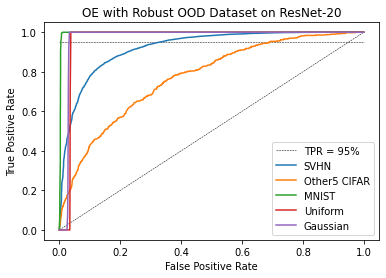

In [115]:
out_softs = [svhn_softs, cifar100_extra_5, MNIST_softs, UNIF_OOD_softmaxes, GAUSSIAN_OOD_softmaxes]
in_softs = [max_softs_in, max_softs_in, max_softs_in, max_softs_in, max_softs_in, max_softs_in]
plot_dataset_rocs(in_softs, out_softs, "OE with Robust OOD Dataset on ResNet-20", ["SVHN", "Other5 CIFAR", "MNIST", "Uniform", "Gaussian"])

In [22]:
odin_SVHN = generate_ODIN_softs(SVHN_loader)
odin_other5 = generate_ODIN_softs(cifar100_5_loader_for_extra)
odin_MNIST = generate_ODIN_softs(MNIST_OOD_loader)
odin_unif = generate_odin_unif_softs()
odin_gaus = generate_odin_gaus_softs()

0/26032
2500/26032
5000/26032
7500/26032
10000/26032
12500/26032
15000/26032
17500/26032
20000/26032
22500/26032
25000/26032
0/500
0/10000
2500/10000
5000/10000
7500/10000


SVHN
FPR at 95%TPR = 0.2841666666666667
TNR at 95%TPR = 0.7158333333333333
AUROC: 0.931805838327188

Other5 CIFAR
FPR at 95%TPR = 0.6779166666666666
TNR at 95%TPR = 0.3220833333333334
AUROC: 0.7826241666666667

MNIST
FPR at 95%TPR = 0.004583333333333333
TNR at 95%TPR = 0.9954166666666666
AUROC: 0.9970542083333334

Uniform
FPR at 95%TPR = 0.03208333333333333
TNR at 95%TPR = 0.9679166666666666
AUROC: 0.9694362500000001

Gaussian
FPR at 95%TPR = 0.025416666666666667
TNR at 95%TPR = 0.9745833333333334
AUROC: 0.9768687500000001



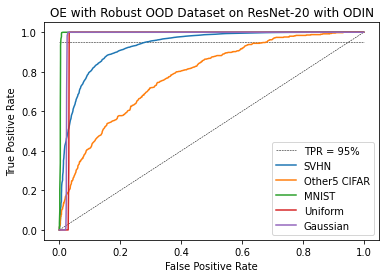

In [23]:
out_softs = [odin_SVHN, odin_other5, odin_MNIST, odin_unif, odin_gaus]
in_softs = [ODIN_softs_in, ODIN_softs_in, ODIN_softs_in, ODIN_softs_in, ODIN_softs_in]
plot_dataset_rocs(in_softs, out_softs, "OE with Robust OOD Dataset on ResNet-20 with ODIN", ["SVHN", "Other5 CIFAR", "MNIST", "Uniform", "Gaussian"])

In [26]:
energy_SVHN = generate_energies(SVHN_loader)
energy_other5 = generate_energies(cifar100_5_loader_for_extra)
energy_MNIST = generate_energies(MNIST_OOD_loader)
energy_unif = generate_energy_unif()
energy_gaus = generate_energy_gaus()

0/26032
2500/26032
5000/26032
7500/26032
10000/26032
12500/26032
15000/26032
17500/26032
20000/26032
22500/26032
25000/26032
0/500
0/10000
2500/10000
5000/10000
7500/10000


SVHN
FPR at 95%TPR = 1.0
TNR at 95%TPR = 0.0
AUROC: 0.0

Other5 CIFAR
FPR at 95%TPR = 1.0
TNR at 95%TPR = 0.0
AUROC: 0.0

MNIST
FPR at 95%TPR = 1.0
TNR at 95%TPR = 0.0
AUROC: 0.0

Uniform
FPR at 95%TPR = 1.0
TNR at 95%TPR = 0.0
AUROC: 0.0

Gaussian
FPR at 95%TPR = 1.0
TNR at 95%TPR = 0.0
AUROC: 0.0



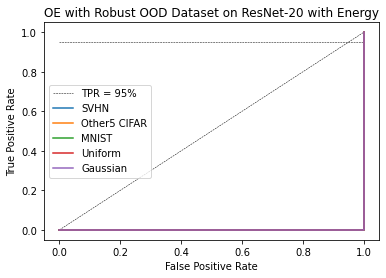

In [27]:
out_softs = [energy_SVHN, energy_other5, energy_MNIST, energy_unif, energy_gaus]
in_softs = [ODIN_softs_in, ODIN_softs_in, ODIN_softs_in, ODIN_softs_in, ODIN_softs_in]
plot_dataset_rocs(out_softs, in_softs, "OE with Robust OOD Dataset on ResNet-20 with Energy", ["SVHN", "Other5 CIFAR", "MNIST", "Uniform", "Gaussian"])

In [22]:
base_baseline_OOD = generate_softs(MNIST_OOD_loader)
base_ODIN_OOD = generate_ODIN_softs(MNIST_OOD_loader)
base_Energy_OOD = generate_energies(MNIST_OOD_loader)

0/10000
2500/10000
5000/10000
7500/10000
0/10000
2500/10000
5000/10000
7500/10000
0/10000
2500/10000
5000/10000
7500/10000


Baseline
FPR at 95%TPR = 0.4625
TNR at 95%TPR = 0.5375
AUROC: 0.853039125

ODIN
FPR at 95%TPR = 0.43833333333333335
TNR at 95%TPR = 0.5616666666666666
AUROC: 0.9025739999999999

Energy
FPR at 95%TPR = 0.4012
TNR at 95%TPR = 0.5988
AUROC: 0.9043008749999998



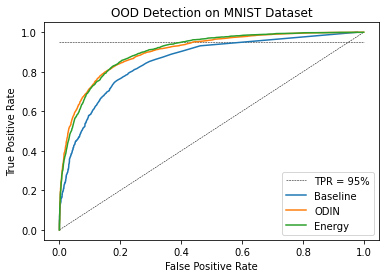

In [23]:
out_softs = [base_baseline_OOD, base_ODIN_OOD, inD_energy]
in_softs = [max_softs_in, ODIN_softs_in, base_Energy_OOD]
plot_dataset_rocs(in_softs, out_softs, "OOD Detection on MNIST Dataset", ["Baseline", "ODIN", "Energy"])